In [2]:
!pip install tensorflow==1.15.3
!pip install umap-learn
!pip install umap-learn[plot]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 110.5 MB 24 kB/s 
     |████████████████████████████████| 50 kB 5.6 MB/s 
     |████████████████████████████████| 3.8 MB 36.1 MB/s 
     |████████████████████████████████| 503 kB 43.7 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=7c945fa48a24f60700e75099eeda7ad9b81b171f648f2b18b78e621380f40528
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting un

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plot
import seaborn as sns

import umap
import umap.plot

import tensorflow as tf
tf.enable_eager_execution()
import tensorflow_hub as tfhub

from collections import Counter
from sklearn import metrics
from numpy import unique
from sklearn.cluster import AgglomerativeClustering

import colorcet as cc

In [4]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('./drive/MyDrive/preprocessed-data.csv')
df.head()

Mounted at /content/drive


,label,text
0,rec.sport.hockey,pens fans pretty confused lack kind posts rece...
1,comp.sys.ibm.pc.hardware,brother market high performance video card sup...
2,talk.politics.mideast,finally dream mediterranean area greater holoc...
3,comp.sys.ibm.pc.hardware,scsi card doing dma transfers disks scsi card ...
4,comp.sys.mac.hardware,[number] old drive cannot understanding driver...


In [5]:
embed_module = "https://tfhub.dev/google/universal-sentence-encoder/4"
embeddings = tfhub.load(embed_module)

def embed_data(input):
  return embeddings([input])

# Applying embedding to text
df['sentence_embedding'] = df['text'].apply(embed_data)

# Dataframe after sentence embedding
df.head()

,label,text,sentence_embedding
0,rec.sport.hockey,pens fans pretty confused lack kind posts rece...,"((tf.Tensor(-0.039444216, shape=(), dtype=floa..."
1,comp.sys.ibm.pc.hardware,brother market high performance video card sup...,"((tf.Tensor(-0.039467365, shape=(), dtype=floa..."
2,talk.politics.mideast,finally dream mediterranean area greater holoc...,"((tf.Tensor(-0.057665743, shape=(), dtype=floa..."
3,comp.sys.ibm.pc.hardware,scsi card doing dma transfers disks scsi card ...,"((tf.Tensor(0.04853781, shape=(), dtype=float3..."
4,comp.sys.mac.hardware,[number] old drive cannot understanding driver...,"((tf.Tensor(-0.052863352, shape=(), dtype=floa..."


In [6]:

# Taking the sentence embeddings as input
X = df.iloc[:,2].values
X[0].shape

X_new = np.array([x.numpy() for x in X]).reshape((df.shape[0],512))
X_new.shape

(18270, 512)

In [7]:
umap_embedding = umap.UMAP(n_components=2).fit(X_new)
umap_embedding.embedding_.shape

(18270, 2)

In [8]:
# Perform Agglomerative clustering
model = AgglomerativeClustering(n_clusters=20)
# Model fitting and prediction
yhat = model.fit_predict(X_new)
# Identify the unique clusters
clusters = unique(yhat)
Counter(yhat)

Counter({18: 677,
         0: 1144,
         9: 540,
         11: 835,
         19: 1018,
         16: 1849,
         10: 985,
         1: 859,
         3: 1338,
         15: 339,
         2: 989,
         4: 1913,
         12: 465,
         5: 1491,
         6: 1525,
         7: 549,
         14: 207,
         17: 427,
         13: 598,
         8: 522})

In [9]:
# Prepare data
umap_data = umap_embedding.fit_transform(X_new)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = yhat


In [10]:

print("EVALUATION METRICS")
print("Completeness: %0.3f" % metrics.completeness_score(df.label, yhat))
print("V-measure: %0.3f" % metrics.v_measure_score(df.label, yhat))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(df.label, yhat))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(df.label, yhat))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_new, yhat, sample_size=1000))

EVALUATION METRICS
Completeness: 0.396
V-measure: 0.387
Homogeneity: 0.379
Adjusted Rand-Index: 0.206
Silhouette Coefficient: 0.005


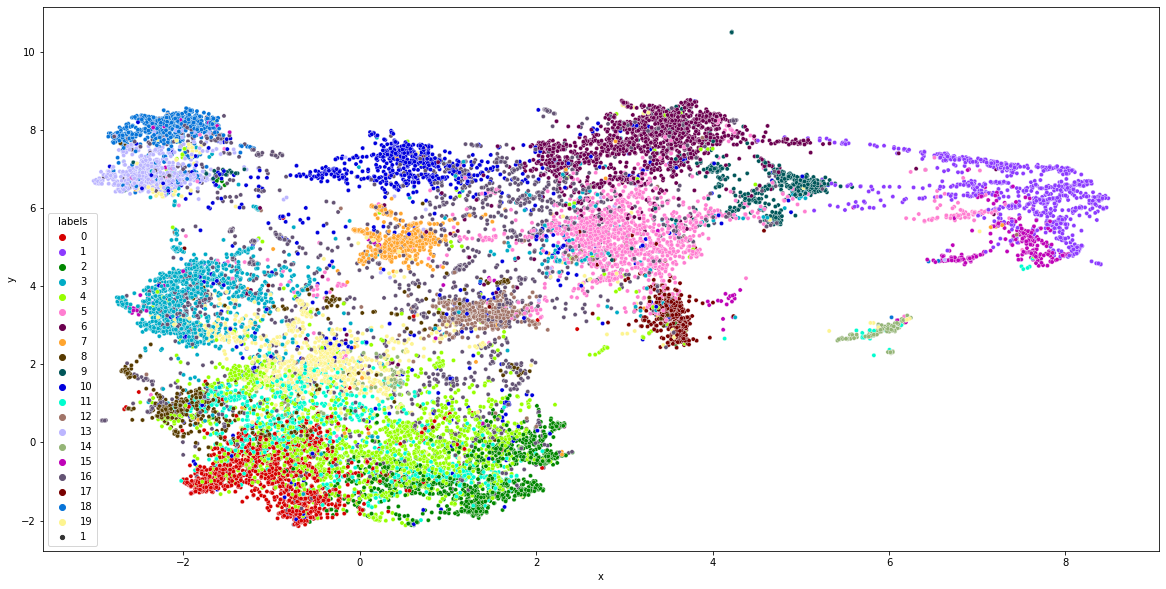

In [11]:


# Visualization
fig, ax = plot.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
palette = sns.color_palette(cc.glasbey, n_colors=20)
sns.scatterplot(data=result, x="x", y="y", hue="labels", size=1, palette=palette)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


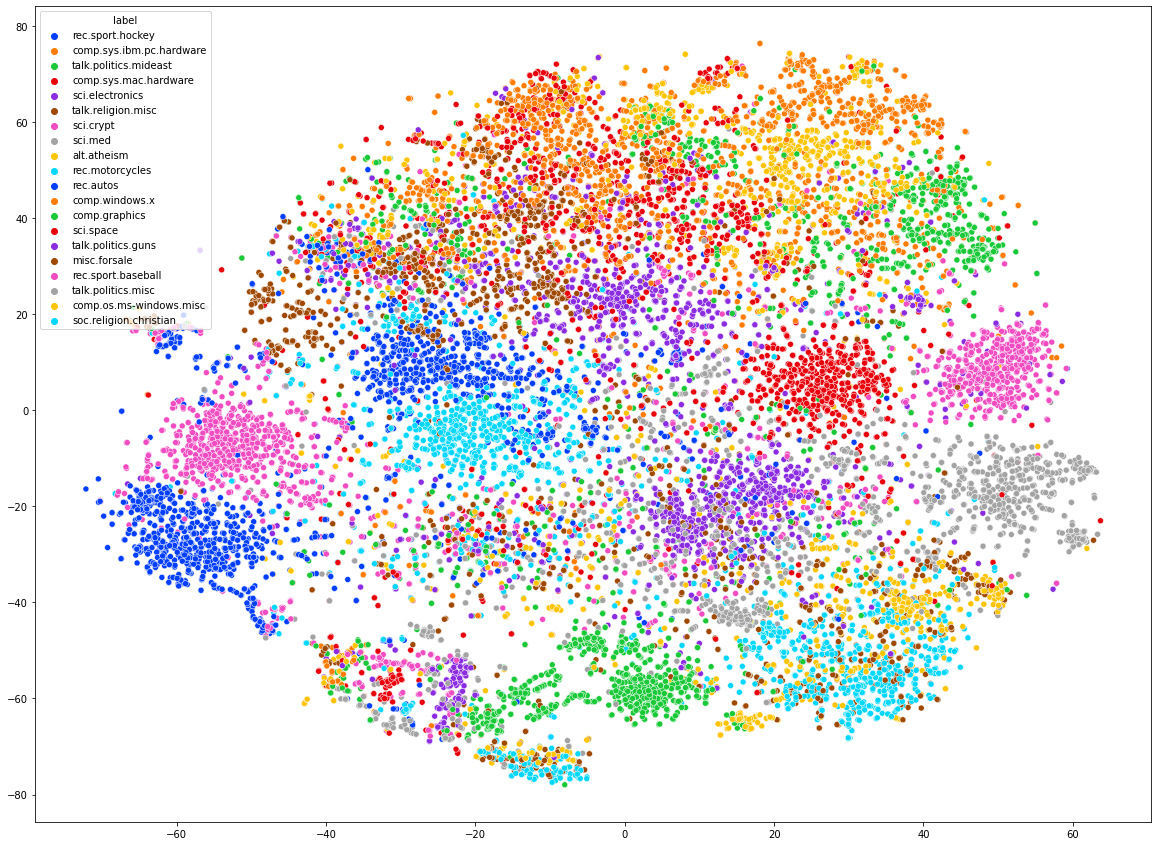

In [13]:
from sklearn.manifold import TSNE
tsne = TSNE()
X_embedded = tsne.fit_transform(X_new)
palette = sns.color_palette("bright", 20)
plot.figure(figsize=(20,15))
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=df['label'], palette=palette)

In [14]:
!pip install cvae

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
# Import CVAE 
from cvae import cvae
cvae_embedder = cvae.CompressionVAE(X_new)
# Train the model 
cvae_embedder.train()

Total amount of data:  16443
Input feature dimension:  512
Calculating normalisation factors.
Normalisation factors calculated.
Total amount of data:  1827
Creating model.
Model created.
Setting up loss.
Loss set up.
Setting up session.
Session set up.
Trying to restore saved checkpoints from /content/temp ... No checkpoint found.
No model found to restore. Initialising new model.
Starting queues.
Reader threads started.
step 0; epoch 0.00 - loss = 256.601, test_loss = 254.612, lr = 0.00100, (0.027 sec/step)
Storing checkpoint to /content/temp ... Done.
step 50; epoch 0.19 - loss = 257.466, test_loss = 252.675, lr = 0.00100, (0.008 sec/step)
step 100; epoch 0.39 - loss = 248.532, test_loss = 242.570, lr = 0.00100, (0.011 sec/step)
step 150; epoch 0.58 - loss = 247.864, test_loss = 231.002, lr = 0.00100, (0.012 sec/step)
step 200; epoch 0.78 - loss = 249.859, test_loss = 228.930, lr = 0.00100, (0.010 sec/step)
step 250; epoch 0.97 - loss = 230.065, test_loss = 227.975, lr = 0.00100, (0.

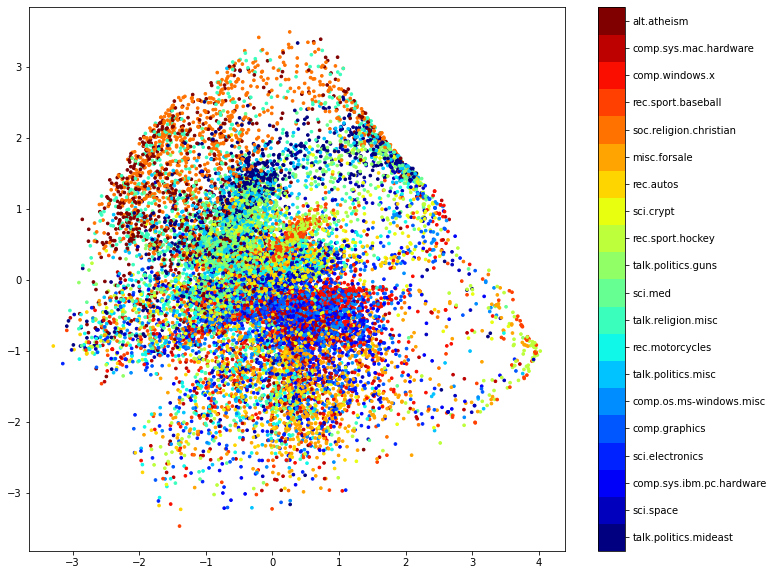

In [16]:
z = cvae_embedder.embed(X_new)
cvae_embedder.visualize(z, labels=df['label'].values)